## Required Packages


**K-means** is one of the most basic clustering algorithms.  It relies on finding cluster centers to group data points based on minimizing the sum of squared errors between each datapoint and its cluster center. One of the limitations is that it depends on the starting point of the clusters, and the number of clusters need to be defined beforehand.

In [1]:
!pip install lets-plot

In [2]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import random
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
import warnings
import operator
from collections import OrderedDict
import itertools
from itertools import *
from lets_plot import *


## Data Preprocessing

In [3]:
df = pd.read_csv('....csv')  # address your filename

In [4]:
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# white spaces and some special characters are hinder in terms syntax so it's better strip them off 
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')\
              .str.replace('$', '').str.replace('-', '_')

In [6]:
df.head(5)


,CustomerID,Gender,Age,Annual_Income_k,Spending_Score_1_100
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.isnull().sum()

CustomerID              0
Gender                  0
Age                     0
Annual_Income_k         0
Spending_Score_1_100    0
dtype: int64

In [8]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)


## Data Visualization

**scatter matrix using GGBunch**

In [9]:
def hist(data, feat, x_lab= True, y_lab = True, width=200, height=200):
    p = ggplot(data) + geom_histogram(aes(feat, '..density..'), alpha=0.7) + ggsize(width, height) \
        + geom_density(aes(feat), color='red', linetype='dashed', size=1)
    if not x_lab:
        p += labs(x='')
    if not y_lab:
        p += labs(y='')
    else:
        p += labs(y=feat)

    p += theme(axis_text='blank', axis_ticks='blank', axis_line='blank')
    return p


In [10]:
def scatter_plot(data, feat1, feat2, x_lab= True, y_lab = True, width=200, height=200):
    p = ggplot(data) + geom_point(aes(feat1, feat2)) + ggsize(width, height)
    if not x_lab:
        p += labs(x='')
    if not y_lab:
        p += labs(y='')

    p += theme(axis_text='blank', axis_ticks='blank', axis_line='blank')
    return p


In [11]:
features = df.iloc[:, 2:].columns.values
n_feat = len(features)

bunch = GGBunch()

x0, y0 = 0, 0
row, col = 0, 0
width, height = 160, 160
step = width + 5
x_lab, y_lab = True, True

for i in range(n_feat**2):
    if col == n_feat:
        col = 0
        row += 1
    x_lab = (row == n_feat - 1)
    y_lab = (col == 0)
    if col == row:
        plot = hist(df.iloc[:, 2:], features[row], x_lab, y_lab, width, height)
    else:
        plot = scatter_plot(df.iloc[:, 2:], features[col], features[row], x_lab, y_lab, width, height)
    bunch.add_plot(plot, x0 + col*step, y0 + row*step, width, height)
    col += 1
bunch.show()


## Data Rescaling


In [12]:
X = df.iloc[:,[3,4]]
X_Robust=RobustScaler().fit_transform(X)
X_Robust=pd.DataFrame(data = X_Robust,columns = X.columns)
X_Robust.head()


,Annual_Income_k,Spending_Score_1_100
0,-1.273973,-0.287582
1,-1.273973,0.810458
2,-1.246575,-1.150327
3,-1.246575,0.705882
4,-1.219178,-0.261438


In [13]:
# display function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    plt.figure(figsize=[6,6])
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'X', s = 100)

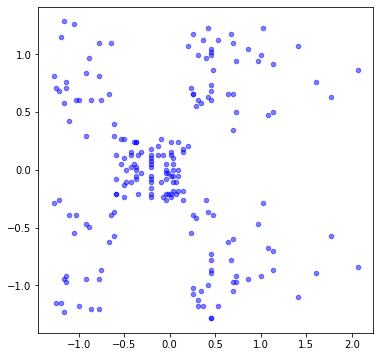

In [14]:
display_cluster(X_Robust.values)

## model test case 1

KMeans is a centeroid based algorithm or distance based. it divides data into set of disjoint clusters which are grouped by randomly alocated centeroid. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion. 

**Tuning Parameter**

    **n_clusters** : The number of clusters to form as well as the number of centroids to generate. To find appropriate number of clusters utilize elbow method or silhouette score.

    init : Method for initialization:

    ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
    ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.
    *n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

    max_iter: Maximum number of iterations of the k-means algorithm for a single run.

    tol: Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.

    **algorithm**: K-means algorithm to use. The classical EM-style algorithm is “full”. The “elkan” variation is more efficient on data with well-defined clusters, by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape (n_samples, n_clusters).



 

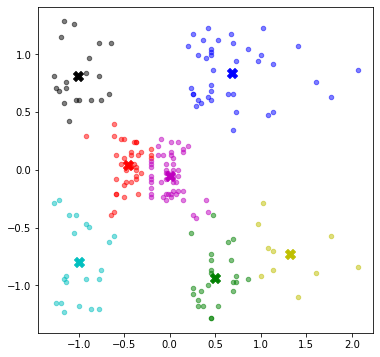

In [15]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X_Robust)
display_cluster(X_Robust.values,km,num_clusters)

## elbow method

  It is sometimes necessary to determine K in a K-means clustering. For these purposes, the elbow method is employed, which uses variance percentages as a variable that varies with cluster numbers. Several clusters are initially selected. This is followed by adding another cluster, but the data modelling does not improve. At this point, the elbow criterion is used to choose the number of clusters. note that: This “elbow” cannot always be unambiguously identified.  

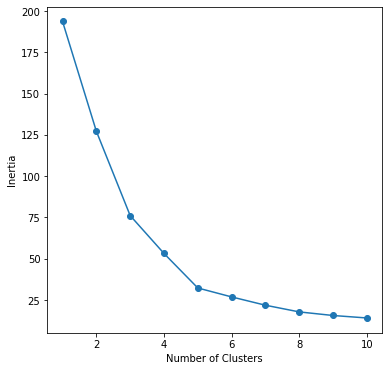

In [16]:
plt.figure(figsize=[6,6])
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_Robust)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

Sometimes, the elbow method does not yield a clear decision (for example, if the elbow is not clear and sharp, or is ambiguous).  In such cases, alternatives such as the [silhouette coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) can be helpful.

## Silhouette Score



silhouette coef or score is a metric used to claculate goodness of clustering technique. it reanges from -1 to 1. higher the value better the teqnique. negative score indicates that cluster is assigned to wrong cluster.




In [17]:
def SilhoutteScore(X):
    SScore=dict()
    for num_clusters in range(2,11):
        kmeans = KMeans(n_clusters=num_clusters,n_jobs=-1,random_state=123).fit(X)
        SScore[num_clusters]=silhouette_score(X, kmeans.labels_)
        SScore = OrderedDict( sorted(SScore.items(), key=operator.itemgetter(1),reverse=True))
    return SScore


In [18]:
SilhoutteScore(X_Robust)


OrderedDict([(5, 0.5516518249155914),
             (6, 0.5390883548184416),
             (7, 0.5284566885380275),
             (4, 0.4909840957730004),
             (3, 0.47029393594847796),
             (8, 0.4630509866683217),
             (9, 0.4603186454118623),
             (10, 0.44183731613429456),
             (2, 0.3347470733819952)])

## model test case2

from the above elbow method we can identified that at 5 clusters, curve bent more 

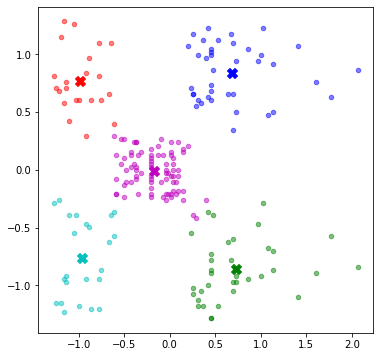

In [19]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X_Robust)
display_cluster(X_Robust.values,km,num_clusters)

## Cluster Analysis

First, we add the cluster labels from the trained model into the copy of the data frame for cluster analysis/visualization.



In [20]:
pred_y = km.fit_predict(X_Robust)
ClusterDF = df.copy()
ClusterDF['labels'] = pred_y
ClusterDF.head()

,CustomerID,Gender,Age,Annual_Income_k,Spending_Score_1_100,labels
0,1,Male,19,15,39,3
1,2,Male,21,15,81,1
2,3,Female,20,16,6,3
3,4,Female,23,16,77,1
4,5,Female,31,17,40,3


## Cluster Plots

In [21]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams["lines.markeredgewidth"] = 1


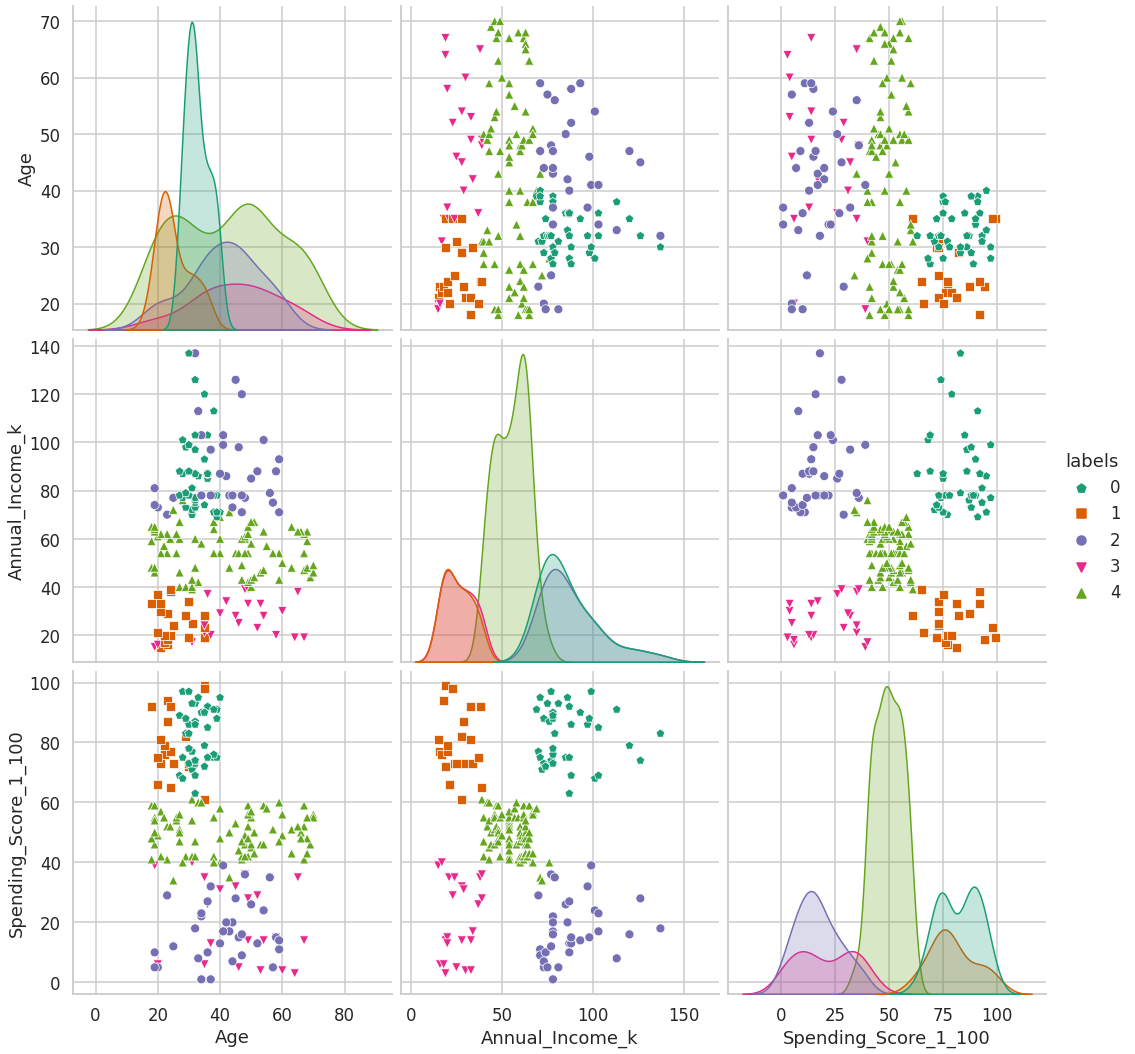

In [22]:
sns.pairplot(data=ClusterDF.iloc[:,1:], hue='labels',  markers=['p', ',', 'o', 'v', '^'], palette='Dark2', height=5)

In [24]:
import plotly.express as px
fig = px.scatter_3d(ClusterDF, x='Spending_Score_1_100', y='Annual_Income_k', z='Age',
              color='labels', symbol='labels', opacity=0.7, size_max=6)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
	
  	

**creator: Virat Chowdary, GitHub: [profile](https://github.com/viratchowdary21)**